# Covid19 Tweet Truth Analysis

Reference:

workshop4.3 Zero-shot classification: https://colab.research.google.com/drive/1Lie9UJyJKONwR7uEdscOp2Qw4vmVlpvx#scrollTo=wEd0QskfGDVR

workshop4.4 https://colab.research.google.com/drive/1B_zidLpksK_pnctPNcnw5dJh4oxgQPfa#scrollTo=H2Zb9jchL-PP

BiLSTM https://colab.research.google.com/drive/1bDY5cg3dpCLDTqiDr0xkoAao5EWs3mKN#scrollTo=tI2_gt9Dtb0X

Attention Map https://colab.research.google.com/drive/1I4ykvsKqwb78hEDRSzzugdDTpWUIDA4e#scrollTo=EbQpyYs13jF_

attention extract https://github.com/hila-chefer/Transformer-Explainability




maxlen = 128: 94% 
maxlen = 512: 

In [ ]:
# setup CUDA
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Data preparation

This dataset contains the training, validation, and test csv's, along with excel documents for the train and test files, a csv with the test file actual values, and ERNIE test results. For this analysis, I will be ignoring the excel files (as they are the same as the csv's) and the ERNIE results. I will be acting as if the test answer file did not exist for the duration of the testing phase as well, thus sticking with a basic approach of train, validate, see what the model decides for the tests.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk #Natural Language Toolkit for Processing
from nltk.corpus import stopwords #Get the Stopwords to Remove

import re #Regular Expressions
import html #Messing with HTML content, like &amp;
import string #String Processing

import tensorflow as tf #Import tensorflow in order to use Keras
from tensorflow.keras.preprocessing.text import Tokenizer #Add the keras tokenizer for tweet tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences #Add padding to help the Keras Sequencing
import tensorflow.keras.layers as L #Import the layers as L for quicker typing
from tensorflow.keras.optimizers import Adam #Pull the adam optimizer for usage

from tensorflow.keras.losses import SparseCategoricalCrossentropy #Loss function being used
from sklearn.model_selection import train_test_split #Train Test Split

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

path = "/content/gdrive/My Drive/PLP_sharing/project/fake_news"
os.chdir(path)

In [ ]:
os.listdir('./')

['covid19-fake-news-dataset-nlp.zip',
 'covid19-fake-news-dataset-nlp-unzip',
 'BiLSTM.ipynb',
 'bert',
 'Transformer-Explainability',
 'lqq_transformer1',
 'lqq_transformer2',
 'w2c-glove',
 'Fake Detection.gdoc',
 'late_fusion',
 'tfidf',
 'early_fusion']

In [ ]:
# !unzip covid19-fake-news-dataset-nlp.zip -d covid19-fake-news-dataset-nlp-unzip

In [ ]:
twTrain = pd.read_csv("./covid19-fake-news-dataset-nlp-unzip/Constraint_Train.csv") #Load the tweet (tw) training set
twTrain.head() #Take a peek at the data

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [ ]:
twValid = pd.read_csv("./covid19-fake-news-dataset-nlp-unzip/Constraint_Val.csv") #Load the tweet (tw) validation set
twValid.head() #Take a peek at the data

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [ ]:
twTest = pd.read_csv("./covid19-fake-news-dataset-nlp-unzip/Constraint_Test.csv") #Load the tweet (tw) testing set
twTest.head() #Take a peek at the data

,id,tweet
0,1,Our daily update is published. States reported...
1,2,Alfalfa is the only cure for COVID-19.
2,3,President Trump Asked What He Would Do If He W...
3,4,States reported 630 deaths. We are still seein...
4,5,This is the sixth time a global health emergen...


---

# Check for Null Values

In [ ]:
print("Training Set:\n", twTrain.isnull().any()) #Check for null values in the training set
print("Validation Set:\n", twValid.isnull().any()) #Check for null values in the validation set
print("Testing Set:\n", twTest.isnull().any()) #Check for null values in the testing set

Training Set:
 id       False
tweet    False
label    False
dtype: bool
Validation Set:
 id       False
tweet    False
label    False
dtype: bool
Testing Set:
 id       False
tweet    False
dtype: bool


There are no null values in the dataset.

---

# Data Exploration

In [ ]:
print(twTrain["tweet"][0]) #Print a simple tweet example
print(twTrain["tweet"][300]) #Print a more typical tweet example

The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.
NEW: There have been numerous #COVID19 outbreaks on recent cruise ship voyages. @CDCDirector has extended the previous No Sail Order to prevent the spread of COVID-19 among crew onboard. https://t.co/OTWJgCN8wQ https://t.co/sbHX4p907F


It appears there are more dry tweets along with more typical tweets (with hashtags and links). The typical tweet examples exist, so I will have to do more usual tweet cleaning.

In [ ]:
print("Training Labels:\n", twTrain["label"].value_counts()) #See the training labels
print("Validation Labels:\n", twValid["label"].value_counts()) #See the validation labels

Training Labels:
 real    3360
fake    3060
Name: label, dtype: int64
Validation Labels:
 real    1120
fake    1020
Name: label, dtype: int64


The labels appear to be pretty balanced in number. I will definitely need to get dummies for these to make real and fake into 1 and 0, but the fact that the labels are balanced in number means the model should pick up on these labels without too much difficulty.

---

# Tweet Processing

In [ ]:
punctuations = string.punctuation #List of punctuations to remove
print(punctuations) #See the punctuations the string library has

STOP = stopwords.words("english") #Get the NLTK stopwords
print(STOP) #See what NLTK considers stopwords

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only

In [ ]:
#CleanTweets: parses the tweets and removes punctuation, stop words, digits, and links.
#Input: the list of tweets that need parsing
#Output: the parsed tweets
def cleanTweets(tweetParse):
    for i in range(0,len(tweetParse)):
        tweet = tweetParse[i] #Putting the tweet into a variable so that it is not calling tweetParse[i] over and over
        tweet = html.unescape(tweet) #Removes leftover HTML elements, such as &amp;
        tweet = re.sub(r"@\w+", " ", tweet) #Completely removes @'s, as other peoples' usernames mean nothing
        tweet = re.sub(r"http\S+", " ", tweet) #Removes links, as links provide no data in tweet analysis in themselves
        
        tweet = "".join([punc for punc in tweet if not punc in punctuations]) #Removes the punctuation defined above
        tweet = tweet.lower() #Turning the tweets lowercase real quick for later use
    
        tweetWord = tweet.split() #Splits the tweet into individual words
        tweetParse[i] = "".join([word + " " for word in tweetWord if not word in STOP]) #Checks if the words are stop words
        
    return tweetParse #Returns the parsed tweets

This code is reworked from my original coronavirus tweet sentiment analysis from earlier in the pandemic (https://www.kaggle.com/lunamcbride24/coronavirus-tweet-processing). I have changed it to use NLTK instead of spacy since those stopwords do not require building a spacy model. I have also used the string library to get punctuation instead of having a bulky hard-coded list and removed the number remover, as I feel that numbers may be a key factor here (especially with the usage of the name Covid-19, since that may have lost the 19 and became just covid, which has a different connotation). These were factors I wanted to change about the original after playing with Keras for TripAdvisor reviews (https://www.kaggle.com/lunamcbride24/hotel-review-keras-classification-project). 

This may be a note to myself, but I did both of those projects half a year ago. This is why you should keep your code well-commented.

In [ ]:
twTrain["cleanTweet"] = cleanTweets(twTrain["tweet"].copy()) #Clean the training tweets
twTrain.head() #Take a look at the dataset

,id,tweet,label,cleanTweet
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently reports 99031 deaths general dis...
1,2,States reported 1121 deaths a small rise from ...,real,states reported 1121 deaths small rise last tu...
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost uses pandemic...
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona 1524 covid testing laborator...
4,5,Populous states can generate large case counts...,real,populous states generate large case counts loo...


In [ ]:
twValid["cleanTweet"] = cleanTweets(twValid["tweet"].copy()) #Clean the validation tweets
twValid.head() #Take a peek at the dataset

,id,tweet,label,cleanTweet
0,1,Chinese converting to Islam after realising th...,fake,chinese converting islam realising muslim affe...
1,2,11 out of 13 people (from the Diamond Princess...,fake,11 13 people diamond princess cruise ship inti...
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,covid19 caused bacterium virus treated aspirin
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,mike pence rnc speech praises donald trump’s c...
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,610 skys explains latest covid19 data governme...


In [ ]:
twTest["cleanTweet"] = cleanTweets(twTest["tweet"].copy()) #Clean the testing tweets
twTest.head() #Take a peek at the dataset

,id,tweet,cleanTweet
0,1,Our daily update is published. States reported...,daily update published states reported 734k te...
1,2,Alfalfa is the only cure for COVID-19.,alfalfa cure covid19
2,3,President Trump Asked What He Would Do If He W...,president trump asked would catch coronavirus ...
3,4,States reported 630 deaths. We are still seein...,states reported 630 deaths still seeing solid ...
4,5,This is the sixth time a global health emergen...,sixth time global health emergency declared in...


---

# Check for Post-Processing Blank Tweets

In [ ]:
print("Training: \n", twTrain.loc[twTrain["cleanTweet"] == ""]) #Check for Training Blank Tweets
print("Validation: \n", twValid.loc[twValid["cleanTweet"] == ""]) #Check for Validation Blank Tweets
print("Testing: \n", twTest.loc[twTest["cleanTweet"] == ""]) #Check for Testing Blank Tweets

Training: 
 Empty DataFrame
Columns: [id, tweet, label, cleanTweet]
Index: []
Validation: 
 Empty DataFrame
Columns: [id, tweet, label, cleanTweet]
Index: []
Testing: 
 Empty DataFrame
Columns: [id, tweet, cleanTweet]
Index: []


In [ ]:
print(twTrain["tweet"][300]) #Print a more typical tweet example
print(twTrain["cleanTweet"][300]) #Print the tweet after processing to show link and stopword removal

NEW: There have been numerous #COVID19 outbreaks on recent cruise ship voyages. @CDCDirector has extended the previous No Sail Order to prevent the spread of COVID-19 among crew onboard. https://t.co/OTWJgCN8wQ https://t.co/sbHX4p907F
new numerous covid19 outbreaks recent cruise ship voyages extended previous sail order prevent spread covid19 among crew onboard 


There were no blank tweets created in any set. Tweets can become blank if they were just user names and links, so I just needed to make sure.

---

# Label Encoding

Interestingly, the get_dummies function in pandas will create encoded labels, since this is a binary classification problem. The real column created by it would have 1 for real and 0 for not real, which necessarily means fake in this case. That is the same as label encoding in this case.

In [ ]:
dummyTrain = pd.get_dummies(twTrain["label"]) #Get the dummies for the training set
print(dummyTrain) #Show the dummies

      fake  real
0        0     1
1        0     1
2        1     0
3        0     1
4        0     1
...    ...   ...
6415     1     0
6416     1     0
6417     1     0
6418     1     0
6419     0     1

[6420 rows x 2 columns]


That real column shows the encoded values for real vs fake. I will be taking the real column as the encoded values.

In [ ]:
twTrain["encodedLabel"] = dummyTrain["real"].astype('int') #Get the encoded labels from the "real" dummies
twTrain.head() #Take a peek at the data

,id,tweet,label,cleanTweet,encodedLabel
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently reports 99031 deaths general dis...,1
1,2,States reported 1121 deaths a small rise from ...,real,states reported 1121 deaths small rise last tu...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost uses pandemic...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona 1524 covid testing laborator...,1
4,5,Populous states can generate large case counts...,real,populous states generate large case counts loo...,1


In [ ]:
twValid["encodedLabel"] = pd.get_dummies(twValid["label"])["real"].astype('int') #Get the encoded labels for the validation set
twValid.head() #Take a peek at the data

,id,tweet,label,cleanTweet,encodedLabel
0,1,Chinese converting to Islam after realising th...,fake,chinese converting islam realising muslim affe...,0
1,2,11 out of 13 people (from the Diamond Princess...,fake,11 13 people diamond princess cruise ship inti...,0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,covid19 caused bacterium virus treated aspirin,0
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,mike pence rnc speech praises donald trump’s c...,0
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,610 skys explains latest covid19 data governme...,1


---

# Tokenizing and Padding

---

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
print(tokenizer.encode("The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today."))

[101, 1996, 26629, 2747, 4311, 5585, 2692, 21486, 6677, 1012, 1999, 2236, 1996, 5860, 2890, 9739, 9243, 1999, 2331, 9294, 2090, 2367, 4216, 2024, 2235, 1998, 4654, 24759, 5555, 3468, 1012, 1996, 2331, 9565, 4832, 2012, 5560, 6694, 8889, 2111, 2651, 1012, 102]


In [ ]:
print(tokenizer.encode_plus("The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.",
                            max_length = 15, padding = 'max_length'))

{'input_ids': [101, 1996, 26629, 2747, 4311, 5585, 2692, 21486, 6677, 1012, 1999, 2236, 1996, 5860, 2890, 9739, 9243, 1999, 2331, 9294, 2090, 2367, 4216, 2024, 2235, 1998, 4654, 24759, 5555, 3468, 1012, 1996, 2331, 9565, 4832, 2012, 5560, 6694, 8889, 2111, 2651, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
print(tokenizer(["This is my dog.", "It's very cute."], 
                max_length = 15, padding = 'max_length', return_tensors = "pt"))

{'input_ids': tensor([[  101,  2023,  2003,  2026,  3899,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2009,  1005,  1055,  2200, 10140,  1012,   102,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}


To set the max_length with a reasonable number, let's find out how long our longest sentence is in the dataset.

In [ ]:
sentences_arr = [twTrain["cleanTweet"], twValid["cleanTweet"], twTest["cleanTweet"]]
sentences = pd.concat(sentences_arr, ignore_index=True)
print(sentences.shape)

sentences = list(sentences)

(10700,)


In [ ]:
max_len = 0

ind = [100,200,300,400,500,512]
for i in ind:
  count = 0
  for typelist in sentences_arr:
    for tweet in typelist:
      max_len = max(max_len, len(tweet))
      if len(tweet)>i:
        count+=1
  print("Count of sentence length over {} is: ".format(i), count)
print('Max sentence length: ', max_len)

Count of sentence length over 100 is:  5877
Count of sentence length over 200 is:  810
Count of sentence length over 300 is:  27
Count of sentence length over 400 is:  11
Count of sentence length over 500 is:  7
Count of sentence length over 512 is:  7
Max sentence length:  6527


In [ ]:
max_len = 128 # 128:94% 

In [ ]:
# encoded_sents = tokenizer(sentences, 
#                           max_length = 128,           # Pad & truncate all sentences.
#                           padding = 'max_length',
#                           truncation=True,
#                           return_attention_mask = True,   # Construct attn. masks.
#                           return_tensors = 'pt'     # Return pytorch tensors.
# )

In [ ]:
# print(encoded_sents['input_ids'].shape)

In [ ]:
encoded_textsTrain = tokenizer(list(twTrain["cleanTweet"]), 
                          max_length = max_len,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
)

In [ ]:
encoded_textsValid = tokenizer(list(twValid["cleanTweet"]), 
                          max_length = max_len,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
) #Collect the tokenized tweet sequences

In [ ]:
# encoded_textsTest = tokenizer(list(twTest["cleanTweet"]), 
#                           max_length = max_len,           # Pad & truncate all sentences.
#                           padding = 'max_length',
#                           truncation=True,
#                           return_attention_mask = True,   # Construct attn. masks.
#                           return_tensors = 'pt'     # Return pytorch tensors.
# ) #Collect the tokenized tweet sequences

In [ ]:
labelsTrain = torch.tensor(twTrain["encodedLabel"])
labelsValid = torch.tensor(twValid["encodedLabel"])

# encoded_labelsTrain = torch.nn.functional.one_hot(labelsTrain.to(torch.int64), 2)
# encoded_labelsValid = torch.nn.functional.one_hot(labelsValid.to(torch.int64), 2)
# encoded_labelsTrain = labelsTrain
# encoded_labelsValid = labelsValid

In [ ]:
print(twTrain["encodedLabel"].dtype)

int64


In [ ]:
# encoded_labelsTrain.shape

In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(encoded_textsTrain['input_ids'], encoded_textsTrain['attention_mask'], labelsTrain)
val_dataset = TensorDataset(encoded_textsValid['input_ids'], encoded_textsValid['attention_mask'], labelsValid)

In [ ]:
labelsTrain.shape

torch.Size([6420])

# Model Arch

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Tofix: RuntimeError: CUDA out of memory.
torch.cuda.empty_cache()

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2 # 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

402


In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Start training the model

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


In [ ]:
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()


# For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        # Accumulate the validation loss.
        loss = outputs.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))       


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    201.    Elapsed: 0:00:17.
  Batch    80  of    201.    Elapsed: 0:00:33.
  Batch   120  of    201.    Elapsed: 0:00:49.
  Batch   160  of    201.    Elapsed: 0:01:05.
  Batch   200  of    201.    Elapsed: 0:01:20.

  Average training loss: 0.30
  Training epoch took: 0:01:20

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.19
  Validation took: 0:00:08

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    201.    Elapsed: 0:00:16.
  Batch    80  of    201.    Elapsed: 0:00:31.
  Batch   120  of    201.    Elapsed: 0:00:47.
  Batch   160  of    201.    Elapsed: 0:01:03.
  Batch   200  of    201.    Elapsed: 0:01:18.

  Average training loss: 0.13
  Training epoch took: 0:01:19

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.19
  Validation took: 0:00:08

Training complete!
Total training took 0:02:56 (h:mm:ss)


In [ ]:
# training_stats

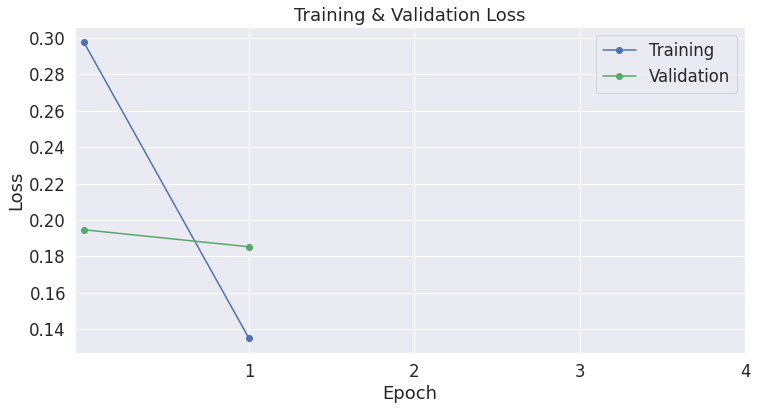

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Evaluation

In [ ]:
from sklearn.metrics import (classification_report, f1_score, recall_score, precision_score, 
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
import matplotlib.pyplot as plt

max_len = 128

# tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     val_text.tolist(),
#     max_length = max_seq_len,
#     pad_to_max_length=True,
#     truncation=True,
#     return_token_type_ids=False
# )

test_text = tokenizer(list(twValid["cleanTweet"]), 
                          max_length = max_len,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
)
# val_dataset = TensorDataset(encoded_textsValid['input_ids'], encoded_textsValid['attention_mask'], labelsValid)
test_seq = torch.tensor(test_text['input_ids'])
test_mask = torch.tensor(test_text['attention_mask'])

with torch.no_grad():
  outputs = model(test_seq.to(device), test_mask.to(device)) # reference: https://www.kaggle.com/akshat0007/bert-for-sequence-classification
  pred_proba = outputs[0].detach().cpu().numpy()
  # pred_proba = pred_proba.cpu().numpy(). # pred_proba.detach().cpu().numpy()

preds = np.argmax(pred_proba, axis = 1)

print([preds.tolist(), pred_proba.tolist()])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,

2140 2140


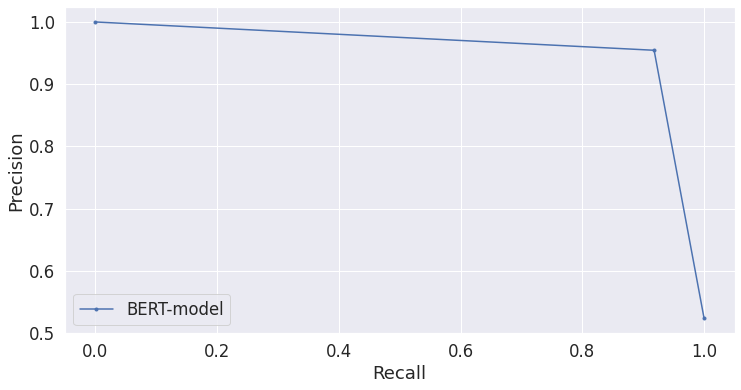


Matthews Corr Coef: 0.8688863360659583
Precision: 0.9545032497678737
Recall: 0.9178571428571428
f-1 score: 0.9341474377178812
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1020
           1       0.95      0.92      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds[0].detach().cpu().numpy()

test_y = twValid["encodedLabel"].tolist()
preds = np.argmax(preds, axis = 1)
print(len(test_y), len(preds))

# model's performance
precision_, recall_, proba = precision_recall_curve(test_y, preds)

#plot precision-recall curve
plt.plot(recall_, precision_, marker='.', label='BERT-model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
# preds = [1 if i >= optimal_proba_cutoff else 0 for i in preds[:, -1]]

mcc = matthews_corrcoef(test_y, preds)
tn, fp, fn, tp = confusion_matrix(test_y, preds).ravel()
precision = precision_score(test_y, preds)
recall = recall_score(test_y, preds)
f1 = f1_score(test_y, preds, average='weighted')

print("")
print("Matthews Corr Coef:", mcc)
print("Precision:", precision)
print("Recall:", recall)
print("f-1 score:", f1)

print(classification_report(test_y, preds))

# Save model

In [ ]:
# MODEL_PATH = "./lqq_transformer1/transformer94.pt"
# torch.save(model.bert.state_dict(), MODEL_PATH)

In [ ]:
import torch
torch.save(model, './lqq_transformer1/model')

# Inference example

In [ ]:
!pip install transformers
!pip install azureml-core

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/PLP_sharing/project/fake_news/"
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch

# saved_model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )
# saved_model.bert.load_state_dict(torch.load('./lqq_transformer1/transformer94.pt'))


saved_model = torch.load('./lqq_transformer1/model')


In [ ]:
from transformers import BertTokenizer
import numpy as np

test_text_fake = 'Alfalfa is the only cure for COVID-19.'
test_text_real = '#IndiaFightsCorona India has one of the lowest #COVID19 mortality globally with less than 2% Case Fatality Rate. As a result of supervised home isolation &amp; effective clinical treatment many States/UTs have CFR lower than the national average. https://t.co/QLiK8YPP7E'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

test_text = tokenizer(list([test_text_fake, test_text_real]), 
                          max_length = 128,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation=True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt'     # Return pytorch tensors.
)
# val_dataset = TensorDataset(encoded_textsValid['input_ids'], encoded_textsValid['attention_mask'], labelsValid)
test_seq = torch.tensor(test_text['input_ids']).to('cuda:0')
test_mask = torch.tensor(test_text['attention_mask']).to('cuda:0')

with torch.no_grad():
  outputs = saved_model(test_seq, test_mask) # reference: https://www.kaggle.com/akshat0007/bert-for-sequence-classification
  pred_proba = outputs[0].detach().cpu().numpy()

preds = np.argmax(pred_proba, axis = 1)

print([preds.tolist(), pred_proba.tolist()])

[[0, 1], [[0.6307932734489441, -0.8636711239814758], [-2.8603923320770264, 2.058260202407837]]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
